In [56]:
%matplotlib inline    
import matplotlib as mplt
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
# matplotlib.style.use('ggplot')

from utils_libs import *

import statsmodels as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import VAR, DynamicVAR

from statsmodels.stats import diagnostic

In [91]:
# ---- Load pre-processed training and testing data ----

file_postfix = "v_minu_mix"

xtrain = np.load("../dataset/bitcoin/training_data/xtrain_"+file_postfix+".dat")
xtest  = np.load("../dataset/bitcoin/training_data/xtest_" +file_postfix+".dat")
ytrain = np.load("../dataset/bitcoin/training_data/ytrain_"+file_postfix+".dat")
ytest  = np.load("../dataset/bitcoin/training_data/ytest_" +file_postfix+".dat")

print np.shape(xtrain), np.shape(ytrain), np.shape(xtest), np.shape(ytest)

print len(gate_tr), len(gate_ts)

(8500, 2) (8500,) (2125, 2) (2125,)
8500 2125


In [58]:
def plot_prediction_truth(file_add, title, left, right):
    test_df = pd.read_csv(file_add, sep=',', names = ['vol','ob'])
    
    fig, ax = plt.subplots()
    fig.set_size_inches( 18,7 )
    
    ax.plot(test_df.iloc[left:right], lw=2)
    ax.legend( ['Prediction','True values'], loc=0)
    ax.set_ylim(-.1, 1.5)
    ax.legend()
    
    plt.title(title)


In [90]:
plot_l = 0
plot_r = 2000

plot_prediction_truth('../bt_results/res/pytest_bayes.txt', 'Bayes regression', plot_l, plot_r)
plot_prediction_truth('../bt_results/res/pytest_enet.txt', 'Elastic net', plot_l, plot_r)
plot_prediction_truth('../bt_results/res/pytest_rf.txt', 'Random forest', plot_l, plot_r)
plot_prediction_truth('../bt_results/res/pytest_gbt.txt', 'Gradient boostet tree', plot_l, plot_r)

plot_prediction_truth('res/pytest.txt', 'Mixture linear', plot_l, plot_r)


(2125, 2) (8500, 2) (2125, 2)


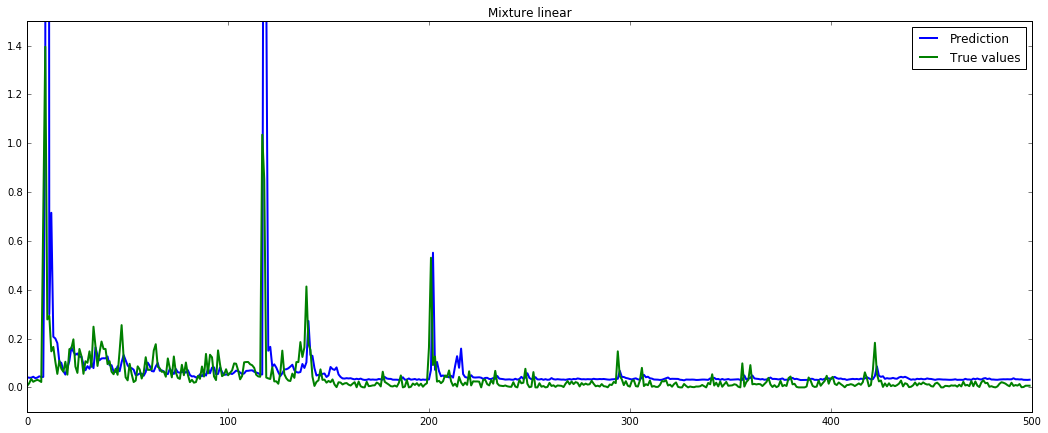

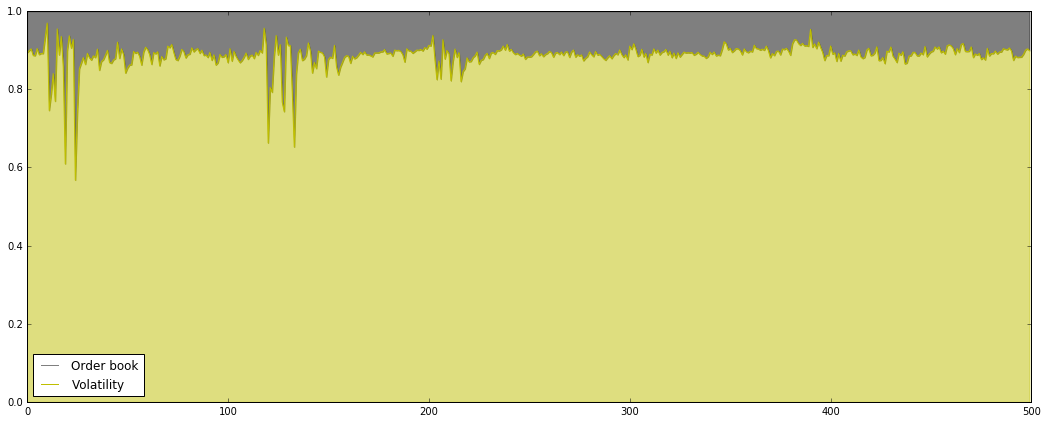

In [106]:
#---- lk linear----

test_df = pd.read_csv('../bt_results/res/pytest.txt',    sep=',', names = ['pred', 'true'])
gate_tr = pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob'])
print test_df.shape, gate_tr.shape, gate_ts.shape

plot_l = 0
plot_r = 500
plot_prediction_truth('../bt_results/res/pytest.txt', 'Mixture linear', plot_l, plot_r)
tmp_gate =  np.asarray(gate_ts.iloc[:plot_horizon])

# for i in range(3, len(tmp_gate)-3):
#      tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i+1, i+2)])

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)

(2125, 2) (8500, 2) (2125, 2)


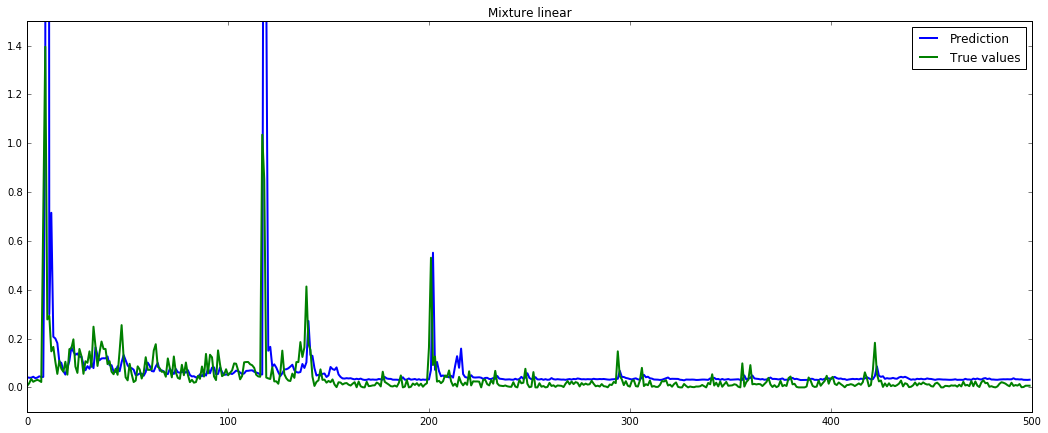

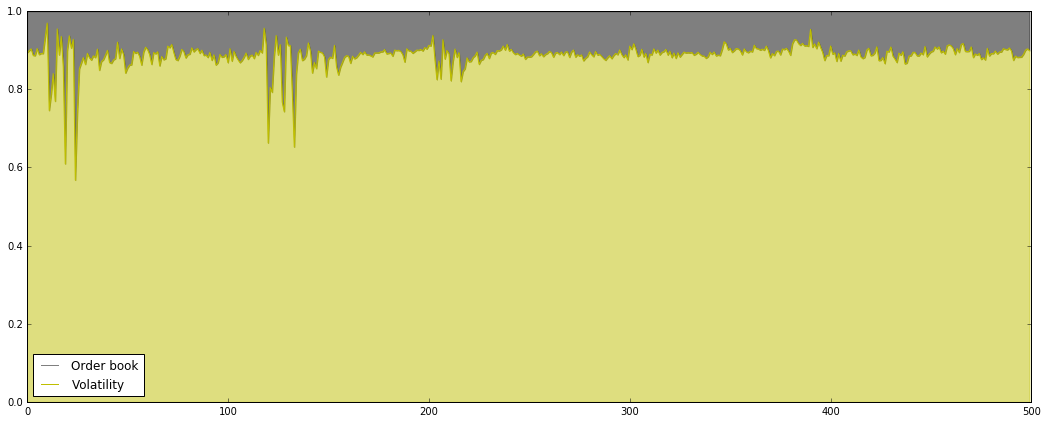

In [107]:
#---- log-norm linear ----

test_df = pd.read_csv('../bt_results/res/pytest.txt',    sep=',', names = ['pred', 'true'])
gate_tr = pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob'])
print test_df.shape, gate_tr.shape, gate_ts.shape

plot_l = 0
plot_r = 500
plot_prediction_truth('../bt_results/res/pytest.txt', 'Mixture linear', plot_l, plot_r)
tmp_gate =  np.asarray(gate_ts.iloc[plot_l:plot_r])

# for i in range(3, len(tmp_gate)-3):
#      tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i+1, i+2)])

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)



(2125, 2) (8500, 2) (2125, 2)


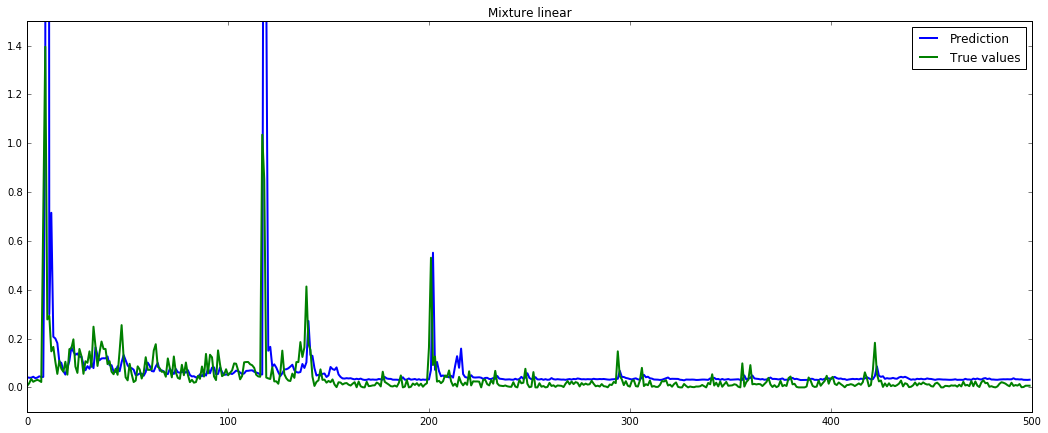

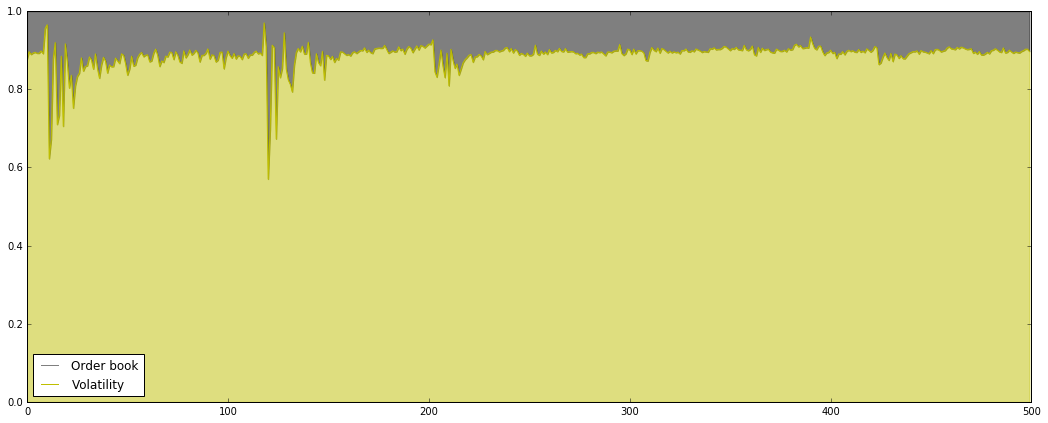

In [130]:
#---- lk bilinear ----

test_df = pd.read_csv('../bt_results/res/pytest.txt',    sep=',', names = ['pred', 'true'])
gate_tr = pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob'])
print test_df.shape, gate_tr.shape, gate_ts.shape

plot_l = 0
plot_r = 500
plot_prediction_truth('../bt_results/res/pytest.txt', 'Mixture linear', plot_l, plot_r)
tmp_gate =  np.asarray(gate_ts.iloc[ : plot_horizon])

# for i in range(3, len(tmp_gate)-3):
#      tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i+1, i+2)])

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)

(2125, 2) (8500, 2) (2125, 2)


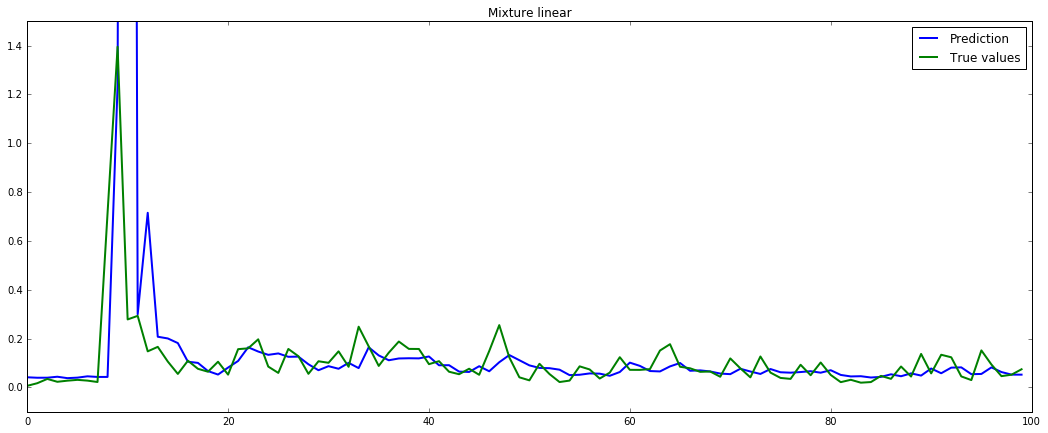

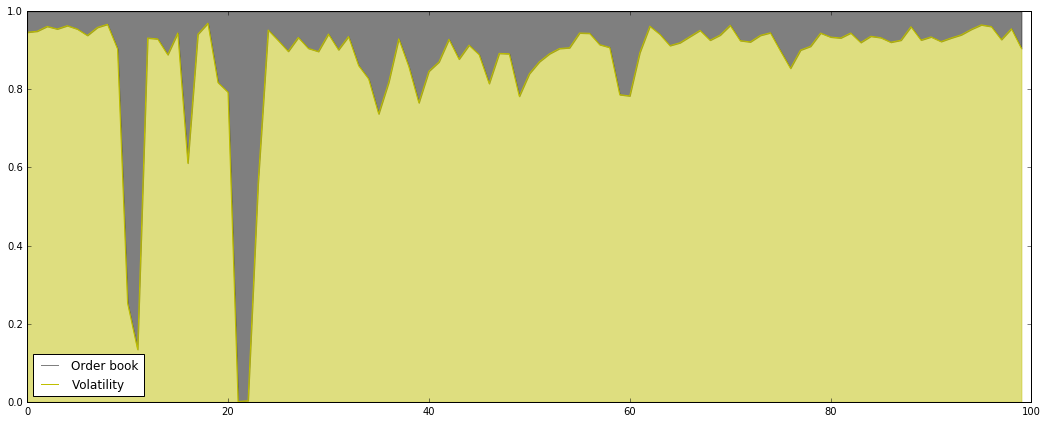

In [105]:
#---- log-norm bi-linear ----

test_df = pd.read_csv('../bt_results/res/pytest.txt',    sep=',', names = ['pred', 'true'])
gate_tr = pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob'])
print test_df.shape, gate_tr.shape, gate_ts.shape

plot_l = 0
plot_r = 500
plot_prediction_truth('../bt_results/res/pytest.txt', 'Mixture linear', plot_l, plot_r)
tmp_gate =  np.asarray(gate_ts.iloc[plot_l:plot_r])

# for i in range(3, len(tmp_gate)-3):
#      tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i+1, i+2)])

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)

In [131]:
# To do: conditiaonl error distribution
# distibution of mixture weights

def vol_condition_on_ob( gate, y, lower, upper ):
   
    tmpv = []
    tmpob= []
    gate = np.asarray(gate)
    for i in range(1,len(gate)):
        tmp_v =  gate[i][0]
        tmp_ob = gate[i][1]
        
        if y[i] >=lower and y[i]<=upper:
            tmpv.append(tmp_v)
            tmpob.append(tmp_ob)
    
    print lower, upper, " : ", len(tmpv), mean(tmpv), mean(tmpob),' p-value: ', sp.stats.ttest_ind(tmpv,tmpob)[1]

print min(ytrain), max(ytrain)
print min(ytest), max(ytest)

print 'Training:'
for i in range(1,50):
    vol_condition_on_ob( gate_tr, ytrain, 0.1*i, 0.1*(i+1) )
    
    
print '\nTesting:'
for i in range(1,30):
    vol_condition_on_ob( gate_ts, ytest, 0.05*i, 0.05*(i+1) )

0.0 4.43378288192
0.0 1.39532489949
Training:
0.1 0.2  :  1834 0.854256561369 0.14574343692  p-value:  0.0
0.2 0.3  :  578 0.818692458516 0.181307540549  p-value:  0.0
0.3 0.4  :  254 0.774692816176 0.225307185569  p-value:  6.95994701619e-154
0.4 0.5  :  120 0.773342787086 0.22665721088  p-value:  2.75602494636e-74
0.5 0.6  :  53 0.724475937913 0.275524065883  p-value:  1.59822881611e-20
0.6 0.7  :  37 0.712773681492 0.28722632032  p-value:  1.33277671825e-16
0.7 0.8  :  34 0.667175863815 0.332824130132  p-value:  6.15331860969e-08
0.8 0.9  :  20 0.777565661073 0.222434344143  p-value:  1.90891800085e-12
0.9 1.0  :  17 0.753240080441 0.246759933584  p-value:  1.88123503747e-09
1.0 1.1  :  15 0.718039936324 0.281960068643  p-value:  0.000202050763371
1.1 1.2  :  10 0.784842070937 0.215157940984  p-value:  1.62176215167e-06
1.2 1.3  :  3 0.79452864329 0.205471371611  p-value:  0.00200992973822
1.3 1.4  :  6 0.794766490658 0.205233520828  p-value:  0.0030311282339
1.4 1.5  :  7 0.8284584

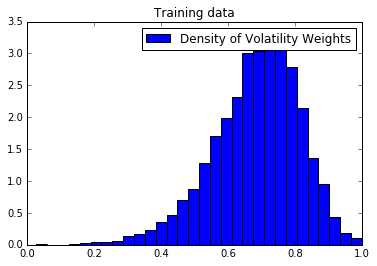

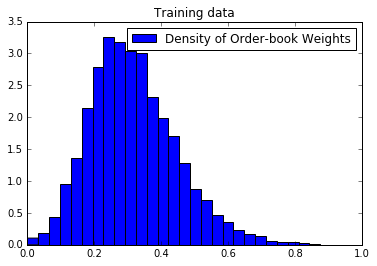

In [228]:
fig, ax = plt.subplots()
ax.hist(gate_tr['vol'], histtype='bar', bins=30, normed= 1, label='Density of Volatility Weights')
ax.legend()
# ax.set_ylim(0,10)
ax.set_xlim(0,1.0)
plt.title("Training data")
# ax.title("Training data")

fig, ax = plt.subplots()
ax.hist(gate_tr['ob'], histtype='bar',  bins=30,normed= 1, label='Density of Order-book Weights')
ax.legend()
# ax.set_ylim(0,10)
ax.set_xlim(0,1.0)
plt.title('Training data')

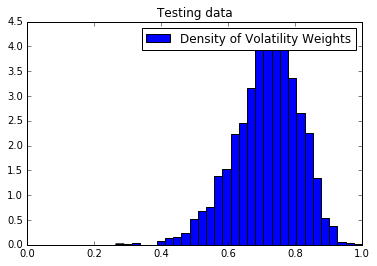

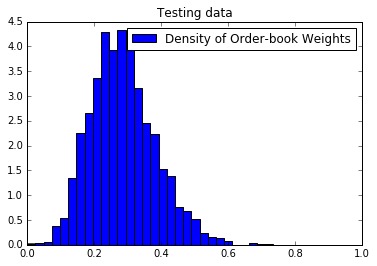

In [229]:
fig, ax = plt.subplots()
ax.hist(gate_ts['vol'], histtype='bar', bins=30, normed= 1, label='Density of Volatility Weights')
ax.legend()
plt.title("Testing data")
# ax.set_ylim(0,600)
ax.set_xlim(0,1.0)

fig, ax = plt.subplots()
ax.hist(gate_ts['ob'], histtype='bar',  bins=30, normed= 1, label='Density of Order-book Weights')
ax.legend(loc=0)
# ax.set_ylim(0,600)
ax.set_xlim(0,1.0)
plt.title('Testing data')

In [1]:
resi = test_df['true']-test_df['pred']

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )
ax.hist(resi, histtype='bar', bins=30, normed= 1)
ax.legend()
# ax.set_ylim(0,10)
# ax.set_xlim(0,1.0)
plt.title("Training data")
# ax.title("Training data")

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )
ax.plot(resi, lw=2)
# ax.legend( ['Prediction','True values'], loc=0)

bitcoin order book
# Ljung–Box test on residuals to test no auto-correlation
print sm.stats.diagnostic.acorr_ljungbox(resi, lags=None, boxpierce=False)[1]

# Normality test
print sp.stats.mstats.normaltest(resi)

sp.stats.kstest(resi, 'norm')

In [ ]:
# prediction error check 

symb = ['gbt', 'rf', 'xgt', 'bayes', 'lasso', 'gp', 'enet', 'ridge', 'arima', 'arimax', 'str', 'strx',\
       'garch', 'egarch']

prefix_ts = 'pytest_'
prefix_tr = 'pytrain_'
postfix = '.txt'

mix_ts = 'mix' + symb[0] + postfix

for i in symb:
    
    



In [ ]:
'''
# backup

#---- log sq ----

test_df = pd.read_csv('res/pytest.txt',    sep=',', names = ['pred', 'true'])
gate_tr = pd.read_csv('res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('res/gate_test.txt', sep=',', names = ['vol','ob'])
print test_df.shape, gate_tr.shape, gate_ts.shape

plot_horizon = 20
plot_prediction_truth('res/pytest.txt', 'Mixture linear', plot_horizon)
tmp_gate =  np.asarray(gate_ts.iloc[:plot_horizon])

# for i in range(3, len(tmp_gate)-3):
#      tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i-1, i+1)])

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)

#---- sq ----

test_df = pd.read_csv('../bt_results/res/pytest.txt',    sep=',', names = ['pred', 'true'])
gate_tr = pd.read_csv('../bt_results/res/gate_train.txt',sep=',', names = ['vol','ob'])
gate_ts = pd.read_csv('../bt_results/res/gate_test.txt', sep=',', names = ['vol','ob'])
print test_df.shape, gate_tr.shape, gate_ts.shape

plot_l = 0
plot_r = 250

plot_prediction_truth('../bt_results/res/pytest.txt', 'Mixture linear', plot_l, plot_r)
tmp_gate =  np.asarray(gate_ts.iloc[plot_l:plot_r])

#for i in range(3, len(tmp_gate)-3):
 #    tmp_gate[i][0] = mean([tmp_gate[j][0] for j in range(i-1, i+1)])

X = range(len(tmp_gate))
Y =  [1.0 for i in tmp_gate ]
Y1 = [i[0] for i in tmp_gate]
Y2 = [0.0 for i in tmp_gate]

fig, ax = plt.subplots()
fig.set_size_inches( 18,7 )

ax.plot(Y, label = 'Order book', color='k', alpha=.5)
ax.plot(Y1,label = 'Volatility', color = 'y')
ax.plot(Y2,)
plt.fill_between(X, Y, Y1, color='k',alpha=.5)
plt.fill_between(X, Y1,Y2, color='y',alpha=.5)

ax.legend(loc=0)